# Justin Trudeau Twitter Topic Modeling

To find out what is on Canadian Prime Minister Justin Trudeau's mind in the COVID-19 pandemic, we gathered his original tweets (i.e. no retweet of others) posted from March 1 to April 27, 2020, and analyzed topics of the tweets by using Latent Dirichlet Allocation (LDA), a generative, probabilistic model for topic clustering/modeling. 

## Twitter Scrape

Import standard python libraries and twitterscraper

In [1]:
from twitterscraper import query_tweets
import datetime 
import pandas as pd
import re, pickle, os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)

In [8]:
KEYWORD = 'JustinTrudeau'   #Twitter handle  
BEGINDATE = datetime.date(2020, 3, 1)
ENDDATE = datetime.date(2020, 4, 27)       
LANG = 'en'
TWEET_QUERY = 'from:'+ KEYWORD
ORIG_TWEET_FILE = r'./data/'+ KEYWORD+'/' + 'all_tweets'

Scrape twitter or load from a saved file

In [9]:
if os.path.isfile(ORIG_TWEET_FILE):        
    with open (ORIG_TWEET_FILE, 'rb') as fp:
        all_tweets_df = pickle.load(fp)
    print('Loaded tweet extracts from file\n')
else:
    print('Start scraping tweets from twitter.com...\n')
    # https://twitter.com/search-advanced
    list_of_tweets = query_tweets(TWEET_QUERY, 
                                  begindate=BEGINDATE, 
                                  enddate=ENDDATE, 
                                  lang=LANG)
    # Convert list of tweets to DataFrame
    all_tweets_df = pd.DataFrame([vars(x) for x in list_of_tweets])
    all_tweets_df.drop_duplicates(subset=['id'], inplace=True)
    all_tweets_df.reset_index(drop=True, inplace=True)
    # Save tweet extracts to file
    save_data_to_pickle(ORIG_TWEET_FILE, all_tweets_df)
    print ('Tweet extracts saved\n')   

Loaded tweet extracts from file



In [4]:
all_tweets_df.head(3)

,fullname,html,id,likes,replies,retweets,text,timestamp,url,user
0,Justin Trudeau,"<p class=""TweetTextSize js-tweet-text tweet-text"" data-aria-label-part=""0"" lang=""en"">Mining has long been a building block of the Canadian economy. And now more than ever, it has an important role to play in our transition to a cleaner future. Today at <a class=""twitter-hashtag pretty-link js-nav"" data-query-source=""hashtag_click"" dir=""ltr"" href=""/hashtag/PDAC2020?src=hash""><s>#</s><b>PDAC2020</b></a>, we spoke about the opportunity Canada has to be the world’s cleanest supplier of metals &amp; minerals.<a class=""twitter-timeline-link u-hidden"" data-pre-embedded=""true"" dir=""ltr"" href=""https://t.co/cs27PXMMmD"">pic.twitter.com/cs27PXMMmD</a></p>",1234626806520483840,931,397,179,"Mining has long been a building block of the Canadian economy. And now more than ever, it has an important role to play in our transition to a cleaner future. Today at #PDAC2020, we spoke about the opportunity Canada has to be the world’s cleanest supplier of metals & minerals.pic.twitter.com/cs27PXMMmD",2020-03-02 23:49:03,/JustinTrudeau/status/1234626806520483840,JustinTrudeau
1,Justin Trudeau,"<p class=""TweetTextSize js-tweet-text tweet-text"" data-aria-label-part=""0"" lang=""en"">After working hard your entire life, you should be able to focus on the people &amp; things you love when you retire. And <a class=""twitter-atreply pretty-link js-nav"" data-mentioned-user-id=""477327043"" dir=""ltr"" href=""/_DebSchulte""><s>@</s><b>_DebSchulte</b></a> will always advocate for your needs. Get to know the aerospace engineer-turned-Minister of Seniors:<a class=""twitter-timeline-link u-hidden"" data-expanded-url=""https://www.everythingzoomer.com/general/politics/2020/03/03/schulte-strong-voice-cabinet/"" dir=""ltr"" href=""https://t.co/VgB1Vo2tKR"" rel=""nofollow noopener"" target=""_blank"" title=""https://www.everythingzoomer.com/general/politics/2020/03/03/schulte-strong-voice-cabinet/""><span class=""tco-ellipsis""></span><span class=""invisible"">https://www.</span><span class=""js-display-url"">everythingzoomer.com/general/politi</span><span class=""invisible"">cs/2020/03/03/schulte-strong-voice-cabinet/</span><span class=""tco-ellipsis""><span class=""invisible""> </span>…</span></a></p>",1235679077459259396,432,117,70,"After working hard your entire life, you should be able to focus on the people & things you love when you retire. And @_DebSchulte will always advocate for your needs. Get to know the aerospace engineer-turned-Minister of Seniors:https://www.everythingzoomer.com/general/politics/2020/03/03/schulte-strong-voice-cabinet/ …",2020-03-05 21:30:24,/JustinTrudeau/status/1235679077459259396,JustinTrudeau
2,Justin Trudeau,"<p class=""TweetTextSize js-tweet-text tweet-text"" data-aria-label-part=""0"" lang=""en"">Javier Pérez de Cuéllar dedicated his life to promoting universal human rights &amp; building a more peaceful world, and his legacy will live on for generations. My deepest condolences to his family &amp; all those whose lives were touched by his remarkable work.<a class=""twitter-timeline-link u-hidden"" data-expanded-url=""https://pm.gc.ca/en/news/statements/2020/03/05/statement-prime-minister-death-javier-perez-de-cuellar"" dir=""ltr"" href=""https://t.co/2s5SxHkCDC"" rel=""nofollow noopener"" target=""_blank"" title=""https://pm.gc.ca/en/news/statements/2020/03/05/statement-prime-minister-death-javier-perez-de-cuellar""><span class=""tco-ellipsis""></span><span class=""invisible"">https://</span><span class=""js-display-url"">pm.gc.ca/en/news/statem</span><span class=""invisible"">ents/2020/03/05/statement-prime-minister-death-javier-perez-de-cuellar</span><span class=""tco-ellipsis""><span class=""invisible""> </span>…</span></a></p>",1235664916977250315,307,28,85,"Javier Pérez de Cuéllar dedicated his life to promoting universal human rights & building a more peaceful world, and his legacy will live on for generations. My de

Number of tweets and average number of words

count    386.000000
mean     41.090674 
std      8.098072  
min      6.000000  
25%      38.000000 
50%      43.000000 
75%      46.000000 
max      56.000000 
Name: text, dtype: float64


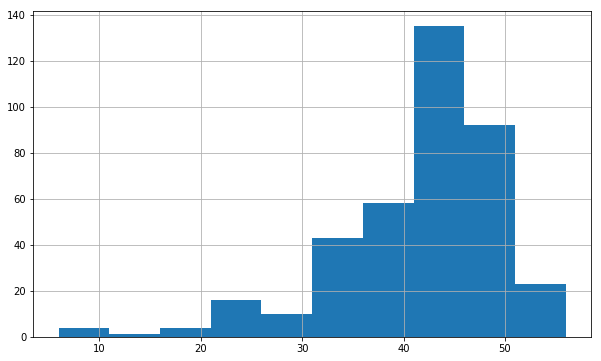

In [5]:
tweets_lens = all_tweets_df['text'].str.split().apply(lambda x: len(x))
print(tweets_lens.describe())
tweets_lens.hist(figsize=(10,6))

## Text clean-up (preprocessing)

In [11]:
import nltk
from nltk.corpus import stopwords, wordnet 
from nltk.stem import WordNetLemmatizer

# Additional stop words to be removed from text
additional_stop_words=['twitter','com','pic','rt','via']

def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def text_cleanup(text):  
    '''
    Text pre-processing
        return tokenized list of cleaned words
    '''
    # Convert to lowercase
    text_clean = text.lower()
    # Remove non-alphabet
    text_clean = re.sub(r'[^a-zA-Z]|(\w+:\/\/\S+)',' ', text_clean).split()    
    # Remove short words (length < 3)
    text_clean = [w for w in text_clean if len(w)>2]
    # Lemmatize text with the appropriate POS tag
    lemmatizer = WordNetLemmatizer()
    text_clean = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text_clean]
    # Filter out stop words in English 
    stops = set(stopwords.words('english')).union(additional_stop_words)
    text_clean = [w for w in text_clean if w not in stops]

    return text_clean
    
cleaned_tweets_df = all_tweets_df.copy(deep=True)
# parsing tweets 
cleaned_tweets_df['token'] = [text_cleanup(x) for x in all_tweets_df['text']]     

print ('Tweets cleanup done')

Tweets cleanup done


Extract bigrams which sometimes offer more meaningful insights of the text.

In [73]:
from nltk.util import ngrams

def word_grams(words, min=1, max=2):
    '''
    Build ngrams word list
    '''
    word_list = []
    for n in range(min, max):
        for ngram in ngrams(words, n):
            word_list.append(' '.join(str(i) for i in ngram))
    return word_list

# Generate bigram tokens
cleaned_tweets_df['bigram_token'] = [word_grams(x, min=2, max=3) for 
                     x in cleaned_tweets_df['token']]
cleaned_tweets_df[['text','token','bigram_token']].head(3)

,text,token,bigram_token
0,"Mining has long been a building block of the Canadian economy. And now more than ever, it has an important role to play in our transition to a cleaner future. Today at #PDAC2020, we spoke about the opportunity Canada has to be the world’s cleanest supplier of metals & minerals.pic.twitter.com/cs27PXMMmD","[mining, long, building, block, canadian, economy, ever, important, role, play, transition, cleaner, future, today, pdac, spoke, opportunity, canada, world, cleanest, supplier, metal, mineral, pxmmmd]","[mining long, long building, building block, block canadian, canadian economy, economy ever, ever important, important role, role play, play transition, transition cleaner, cleaner future, future today, today pdac, pdac spoke, spoke opportunity, opportunity canada, canada world, world cleanest, cleanest supplier, supplier metal, metal mineral, mineral pxmmmd]"
1,"After working hard your entire life, you should be able to focus on the people & things you love when you retire. And @_DebSchulte will always advocate for your needs. Get to know the aerospace engineer-turned-Minister of Seniors:https://www.everythingzoomer.com/general/politics/2020/03/03/schulte-strong-voice-cabinet/ …","[work, hard, entire, life, able, focus, people, thing, love, retire, debschulte, always, advocate, need, get, know, aerospace, engineer, turn, minister, senior]","[work hard, hard entire, entire life, life able, able focus, focus people, people thing, thing love, love retire, retire debschulte, debschulte always, always advocate, advocate need, need get, get know, know aerospace, aerospace engineer, engineer turn, turn minister, minister senior]"
2,"Javier Pérez de Cuéllar dedicated his life to promoting universal human rights & building a more peaceful world, and his legacy will live on for generations. My deepest condolences to his family & all those whose lives were touched by his remarkable work.https://pm.gc.ca/en/news/statements/2020/03/05/statement-prime-minister-death-javier-perez-de-cuellar …","[javier, rez, llar, dedicate, life, promote, universal, human, right, building, peaceful, world, legacy, live, generation, deepest, condolence, family, whose, life, touch, remarkable, work]","[javier rez, rez llar, llar dedicate, dedicate life, life promote, promote universal, universal human, human right, right building, building peaceful, peaceful world, world legacy, legacy live, live generation, generation deepest, deepest condolence, condolence family, family whose, whose life, life touch, touch remarkable, remarkable work]"


## Word Count and Word Cloud

In [18]:
# Convert series to list for word count
tweets_text = [word for one_tweet in cleaned_tweets_df['token'] for word in one_tweet]

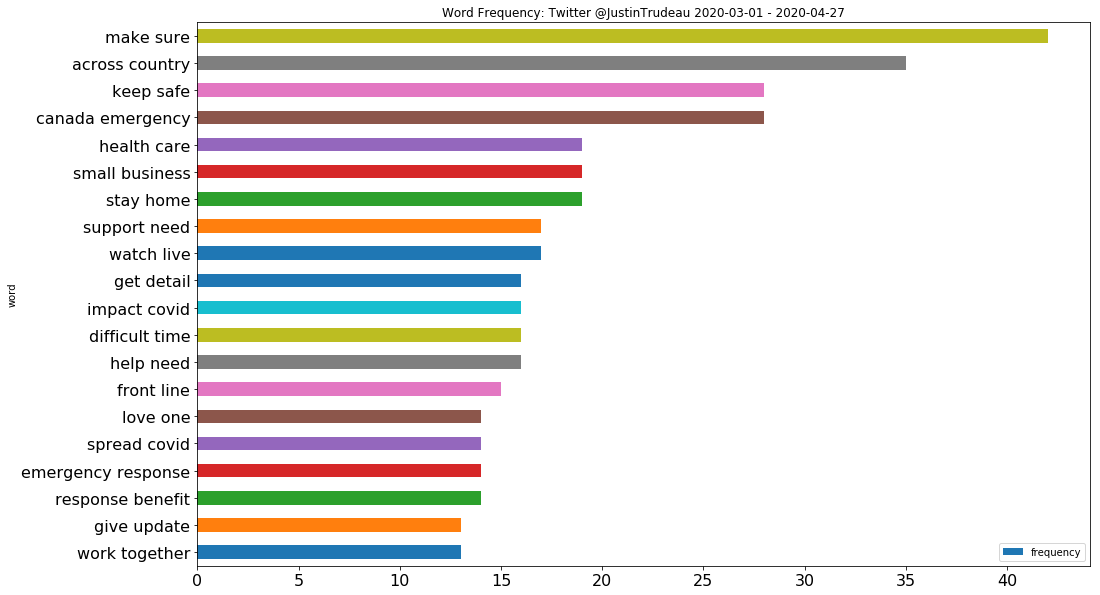

In [74]:
from collections import Counter

n_grams = list(ngrams(tweets_text, 2))
common_words = Counter(n_grams).most_common()
word_count = pd.DataFrame(data = common_words, columns=['word','frequency']) 
# Convert list to string
word_count['word'] = word_count['word'].apply(' '.join)

# Plot word count graph
title = "Word Frequency: Twitter @{} {} - {}".format(KEYWORD, BEGINDATE, ENDDATE)
word_count.head(20).sort_values('frequency').plot.barh(x='word', y='frequency', title=title,figsize=(16,10), fontsize=16)

In [24]:
word_count.head(20)

,word,frequency
0,make sure,42
1,across country,35
2,keep safe,28
3,canada emergency,28
4,health care,19
5,small business,19
6,stay home,19
7,watch live,17
8,support need,17
9,get detail,16


(-0.5, 1599.5, 1199.5, -0.5)

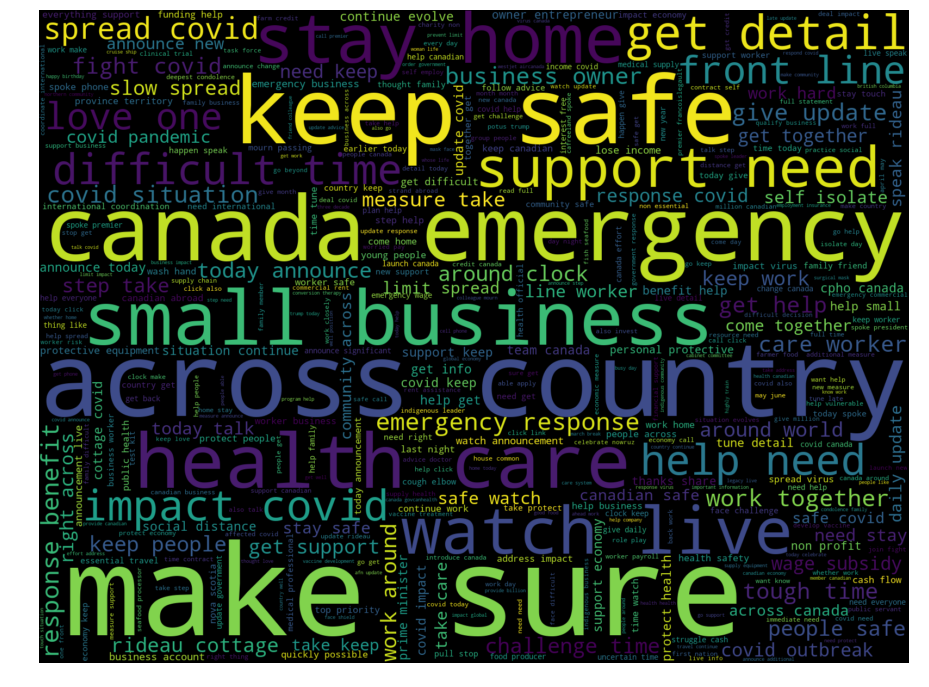

In [76]:
from wordcloud import WordCloud

# Convert DataFrame to map so that word cloud can be generated from freq
word_count_dict = {}
for w, f in word_count.values:
    word_count_dict[w] = f
# Generate word cloud 
wordcloud = WordCloud(max_words=400, width=1600, height=1200, 
                      random_state=12, contour_width=3,
                      contour_color='firebrick')
wordcloud.generate_from_frequencies(word_count_dict)    
plt.figure(figsize=(16,12)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

## Topic Modeling

In [35]:
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel

Use unigrams for LDA training

In [36]:
# ----------------------
# LDA model hyper-parameters
# ----------------------
# Number of training passes
num_passes = 50 
# Document-Topic Density
alpha = 'auto'
# Word-Topic Density
eta = 'auto'

In [37]:
no_below = 10
no_above = 0.5

def build_corpus_dict(token_docs):
    docs_dict = corpora.Dictionary(token_docs)
    # Remove words that occur less than 10 documents or more than 50% of the doc
    docs_dict.filter_extremes(no_below, no_above)
    # Transform doc to a vectorized form by computing frequency of each word
    bow_corpus = [docs_dict.doc2bow(doc) for doc in token_docs]           
    # Create tf-idf model and then apply transformation to the entire corpus
    tfidf_corpus = models.TfidfModel(bow_corpus)[bow_corpus]

    return tfidf_corpus, docs_dict

In [38]:
def train_lda_model(num_topics, token_docs, tfidf_corpus, docs_dict):         
    # Train LDA model
    lda_model = models.ldamodel.LdaModel(corpus=tfidf_corpus, 
                                         num_topics=num_topics, 
                                         id2word=docs_dict, 
                                         passes=num_passes, 
                                         alpha=alpha, 
                                         eta=eta,
                                         random_state=49)
    
    # Evaluate LDA model performance by computing Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=token_docs, 
                                         dictionary=docs_dict, coherence='c_v')   
    coherence_value = coherence_model_lda.get_coherence()        
    print("Coherence value of", num_topics, "topics is", round(coherence_value,4))

    return lda_model, coherence_value

Search for the optimal number of topics to train LDA model

In [46]:
# Build dictionary
tfidf_corpus, docs_dict = build_corpus_dict(cleaned_tweets_df['token'])

In [47]:
# Range of number of topics 
start=2; limit=21; step=2;
print('Searching optimal number of topics for LDA model ...') 
coherence_values = []
model_list = []
for num_topics in range(start, limit, step):            
    lda_model, coherence_value = train_lda_model(num_topics, cleaned_tweets_df['token'], tfidf_corpus, docs_dict)
    model_list.append(lda_model)
    coherence_values.append(coherence_value)

Searching optimal number of topics for LDA model ...

Coherence value of 2 topics is 0.2827
Coherence value of 4 topics is 0.372
Coherence value of 6 topics is 0.3733
Coherence value of 8 topics is 0.3599
Coherence value of 10 topics is 0.3639
Coherence value of 12 topics is 0.3368
Coherence value of 14 topics is 0.3374
Coherence value of 16 topics is 0.3261
Coherence value of 18 topics is 0.3222
Coherence value of 20 topics is 0.3287


Text(0, 0.5, 'Coherence Value')

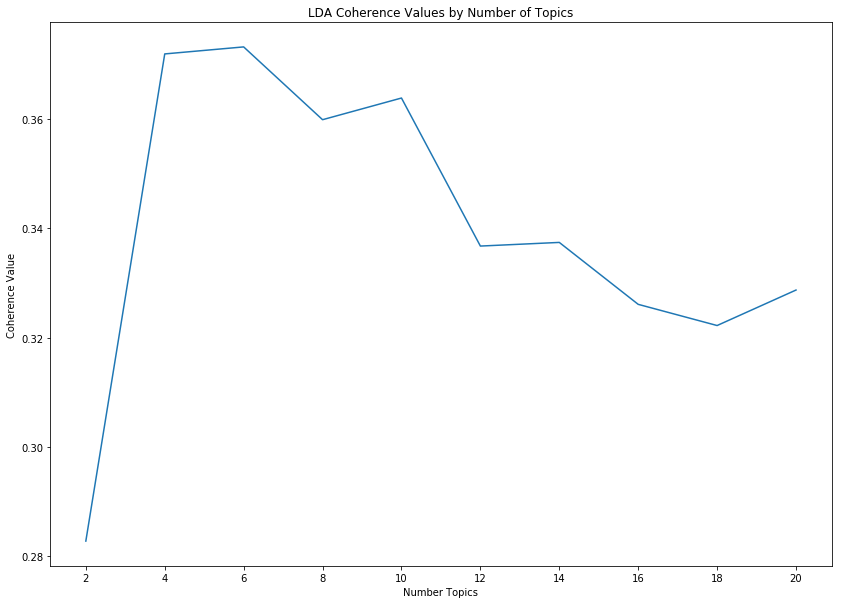

In [48]:
# Plot coherence values       
x = range(start, limit, step)   
plt.figure(figsize=(14,10))
plt.title('LDA Coherence Values by Number of Topics')
plt.plot(x, coherence_values)
plt.xticks(x)
plt.xlabel("Number Topics")
plt.ylabel("Coherence Value")

Optimal number of topics is 6 which has the highest CV.

In [49]:
num_topics = 6 
print('Starting LDA model training for', num_topics, 'topics') 
lda_model, coherence_value = train_lda_model(num_topics, cleaned_tweets_df['token'], tfidf_corpus, docs_dict)

Starting LDA model training for 6 topics
Coherence value of 6 topics is 0.3733


Gather all learned topics and give them a label using the top 4 keywords of the topic.

In [55]:
top_n_keywords = 4
topics_pd = pd.DataFrame() 
# Label topics using top 4 keywords of the topic
for idx, topic in lda_model.print_topics():
    topic_desc = '-'.join([x[0] for x in lda_model.show_topic(idx,top_n_keywords)])
    topics_pd = topics_pd.append(pd.Series([idx,topic_desc, topic]), ignore_index=True)        
topics_pd.columns = ['topic_num','topic_desc','topic_keywords']
topics_pd

,topic_num,topic_desc,topic_keywords
0,0.0,business-small-help-owner,"0.054*""business"" + 0.034*""small"" + 0.026*""help"" + 0.025*""owner"" + 0.024*""support"" + 0.023*""announce"" + 0.020*""non"" + 0.020*""detail"" + 0.019*""announcement"" + 0.019*""emergency"""
1,1.0,spoke-international-talk-spread,"0.040*""spoke"" + 0.034*""international"" + 0.031*""talk"" + 0.030*""spread"" + 0.029*""call"" + 0.029*""impact"" + 0.029*""today"" + 0.028*""covid"" + 0.026*""leader"" + 0.025*""economy"""
2,2.0,benefit-test-lose-apply,"0.051*""benefit"" + 0.036*""test"" + 0.034*""lose"" + 0.033*""apply"" + 0.033*""emergency"" + 0.029*""month"" + 0.028*""receive"" + 0.025*""response"" + 0.025*""year"" + 0.023*""invest"""
3,3.0,make-work-need-sure,"0.024*""make"" + 0.022*""work"" + 0.020*""need"" + 0.018*""sure"" + 0.018*""continue"" + 0.018*""country"" + 0.018*""keep"" + 0.017*""health"" + 0.016*""home"" + 0.016*""safe"""
4,4.0,celebrate-hope-life-around,"0.053*""celebrate"" + 0.042*""hope"" + 0.038*""life"" + 0.037*""around"" + 0.036*""clock"" + 0.031*""please"" + 0.030*""full"" + 0.026*""year"" + 0.022*""late"" + 0.022*""world"""
5,5.0,one-update-watch-family,"0.026*""one"" + 0.024*""update"" + 0.023*""watch"" + 0.023*""family"" + 0.022*""time"" + 0.021*""friend"" + 0.021*""kid"" + 0.019*""give"" + 0.019*""great"" + 0.018*""live"""


Label each tweet with the most probable topic that is learned by LDA model.

In [59]:
docs_topic_dist = lda_model.get_document_topics(tfidf_corpus)
# Topic with the highest score i.e. most probable topic
docs_probable_topic_dist = [sorted(l,key=lambda x: x[1], reverse=True)[0] for l in docs_topic_dist]

# Get most probably topic number and probablity for each tweet
docs_topic = pd.DataFrame({'topic_num': [t[0] for t in docs_probable_topic_dist],
                           'probability': [t[1] for t in docs_probable_topic_dist]})
# Add topic label
docs_topic = docs_topic.merge(topics_pd[['topic_num','topic_desc']], how='left', on='topic_num') 

# Label tweets with topics
tweets_with_topic = pd.concat([docs_topic, cleaned_tweets_df[['token','text']]], axis=1, sort=False)
tweets_with_topic.head(10)

,topic_num,probability,topic_desc,token,text
0,3,0.876077,make-work-need-sure,"[mining, long, building, block, canadian, economy, ever, important, role, play, transition, cleaner, future, today, pdac, spoke, opportunity, canada, world, cleanest, supplier, metal, mineral, pxmmmd]","Mining has long been a building block of the Canadian economy. And now more than ever, it has an important role to play in our transition to a cleaner future. Today at #PDAC2020, we spoke about the opportunity Canada has to be the world’s cleanest supplier of metals & minerals.pic.twitter.com/cs27PXMMmD"
1,4,0.859025,celebrate-hope-life-around,"[work, hard, entire, life, able, focus, people, thing, love, retire, debschulte, always, advocate, need, get, know, aerospace, engineer, turn, minister, senior]","After working hard your entire life, you should be able to focus on the people & things you love when you retire. And @_DebSchulte will always advocate for your needs. Get to know the aerospace engineer-turned-Minister of Seniors:https://www.everythingzoomer.com/general/politics/2020/03/03/schulte-strong-voice-cabinet/ …"
2,4,0.791011,celebrate-hope-life-around,"[javier, rez, llar, dedicate, life, promote, universal, human, right, building, peaceful, world, legacy, live, generation, deepest, condolence, family, whose, life, touch, remarkable, work]","Javier Pérez de Cuéllar dedicated his life to promoting universal human rights & building a more peaceful world, and his legacy will live on for generations. My deepest condolences to his family & all those whose lives were touched by his remarkable work.https://pm.gc.ca/en/news/statements/2020/03/05/statement-prime-minister-death-javier-perez-de-cuellar …"
3,5,0.823592,one-update-watch-family,"[mike, babad, know, humour, insight, energy, author, columnist, editor, mentor, contribution, journalism, canada, vast, forgotten, thought, family, friend, colleague, mourn, passing]","Mike Babad was known for his humour, his insights, and his energy. And as an author, columnist, editor, and mentor, his contributions to journalism in Canada were vast and will not be forgotten. My thoughts are with his family, friends, and colleagues as they mourn his passing."
4,2,0.841823,benefit-test-lose-apply,"[since, million, canadian, lift, poverty, mean, family, money, pocket, senior, enjoy, retirement, young, people, like, met, esbgc, today, able, reach, full, potential, yesrzedyd]","Since 2015, over 1 million Canadians have been lifted out of poverty. And that means more families have more money in their pockets, more seniors can enjoy their retirement, and more young people - like those we met at @esbgc today - are able to reach their full potential.pic.twitter.com/5YesRZedYd"
5,0,0.816397,business-small-help-owner,"[climate, change, challenge, force, company, rethink, business, also, opportunity, innovate, sustainable, saint, jerome, lionelectricco, example, canadian, ingenuity, help, tackle, climate, crisis, szdvjd]","Climate change is a challenge that’s forcing companies to rethink how they do business, but it’s also an opportunity for them to innovate & be more sustainable. And in Saint-Jerome, @LionElectricCo is an example of how Canadian ingenuity can help us tackle the climate crisis.pic.twitter.com/SzdvJD00oE"
6,1,0.612857,spoke-international-talk-spread,"[top, priority, keep, canadian, safe, covid, spread, around, world, create, new, cabinet, committee, build, work, prevent, limit, spread, virus, canada, monitor, economic, impact]","Our top priority is keeping Canadians safe. With COVID-19 spreading around the world, we are creating a new Cabinet committee to build on the work we’ve been doing to prevent & limit the spread of the virus in Canada, and to monitor its economic impacts.https://pm.gc.ca/en/news/news-releases/2020/03/04/prime-minister-creates-committee-covid-19 …"
7,3,0.568548,make-work-need-sure,"[new, member, canadian, family, thank, choose, canada, make, country, strong, future, brighter, glad, cou

Tweet topic distribution in percentage

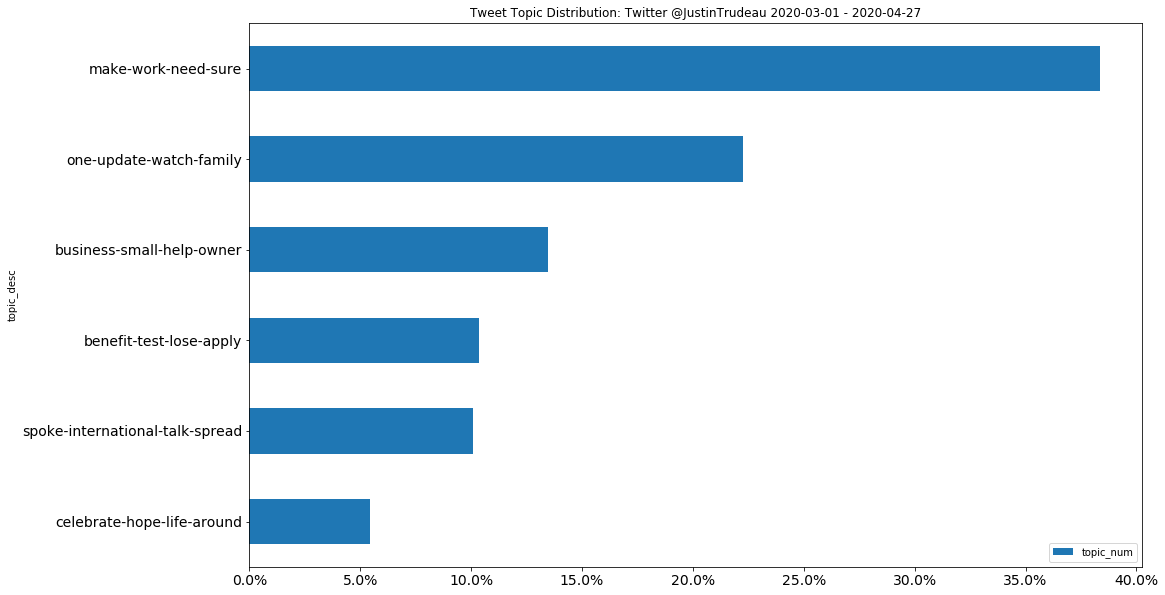

In [75]:
import matplotlib.ticker as mtick
topic_distribution = tweets_with_topic.groupby('topic_desc').count()[['topic_num']].sort_values(['topic_num'])/tweets_with_topic.shape[0]
title = "Tweet Topic Distribution: Twitter @{} {} - {}".format(KEYWORD, BEGINDATE, ENDDATE)
ax = topic_distribution.plot.barh(figsize=(16,10),fontsize=14, title=title)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))

## Visualize Topics

In [72]:
import pyLDAvis.gensim
lda_data =  pyLDAvis.gensim.prepare(lda_model, tfidf_corpus, docs_dict, mds='mmds')
pyLDAvis.display(lda_data)